# Introduction

## Dataset Description

**Source**: German Credit Data (`credit-g` from OpenML, dataset ID 31)  
**File**: `dataset_31_credit-g.arff`  
**Size**: 1,000 instances with 21 attributes (20 features + 1 target)

The dataset contains information about credit applicants with a mix of categorical and numerical features:
- **Numerical features (7)**: duration, credit_amount, installment_commitment, residence_since, age, existing_credits, num_dependents
- **Categorical features (13)**: checking_status, credit_history, purpose, savings_status, employment, personal_status, other_parties, property_magnitude, other_payment_plans, housing, job, own_telephone, foreign_worker
- **Target variable**: `class` (binary: "good" or "bad" credit risk)

## Machine Learning Task

**Task Type**: Binary Classification  
**Objective**: Predict whether an individual is a good or bad credit risk based on their financial and personal attributes.

**Why This Task Matters**:  
Credit risk assessment is a critical real-world application in financial institutions. Accurate classification helps:
- Reduce financial losses from defaults
- Make fair and consistent lending decisions
- Identify both obvious and subtle risk factors
- Balance approval rates with risk management

Misclassifying a bad credit risk as good (false positive) is particularly costly as it can lead to loan defaults, while misclassifying a good applicant as bad (false negative) results in lost business opportunities.

# Unsupervised Learning and Data Preprocessing

In [17]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

## 1. Load Data

In [2]:
# Load the ARFF file
data, meta = arff.loadarff('dataset_31_credit-g.arff')
df = pd.DataFrame(data)
#Getting rid of byte strings
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode('utf-8')
#print(df) #test to see if df works

# Feature Distribution Visualization

Visualizing the distribution of key features to understand the data.


## 1.1 Histograms of Key Numerical Features


Histograms


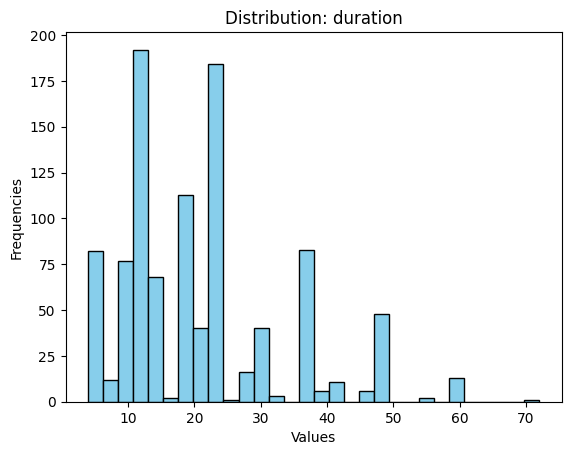

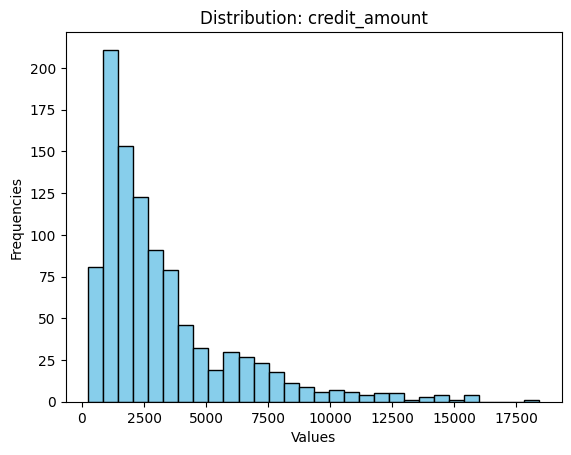

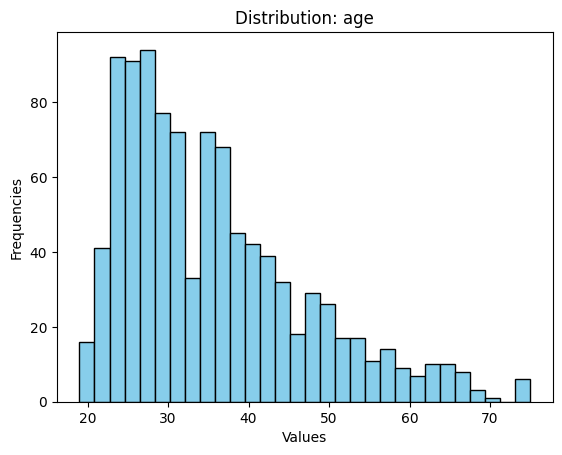

In [3]:
DIVIDER = "==================================================="
#Interesting histograms
print(DIVIDER)
print("Histograms")
print(DIVIDER)
for col in df.columns:
    if col in ["duration", "credit_amount","age"]:
        plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
        plt.title(f"Distribution: {col}")
        plt.xlabel('Values')
        plt.ylabel('Frequencies')
        plt.show()


## 1.2 Correlation Matrix


Correlation Matrix


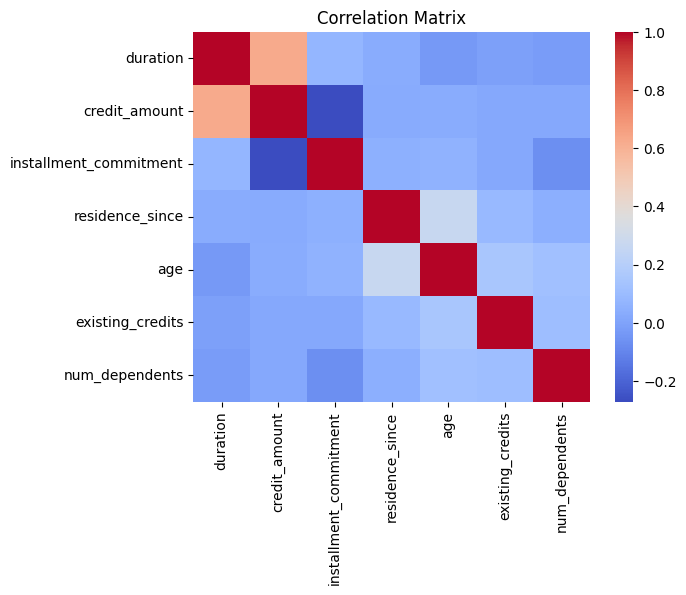

In [4]:
#Correlation Matrix
print(DIVIDER)
print("Correlation Matrix")
print(DIVIDER)

numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## 1.3 Relationships with Target Variable


Relationship with target variable


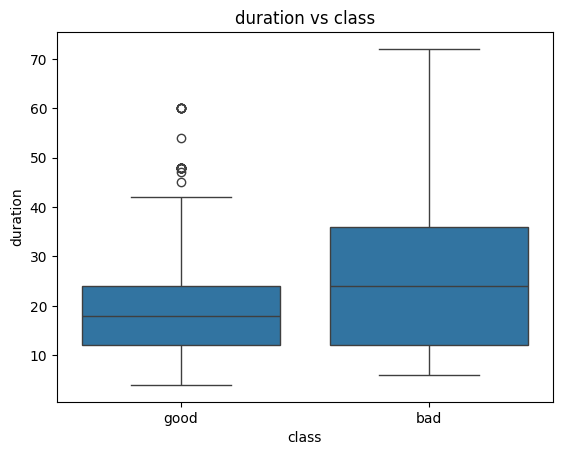

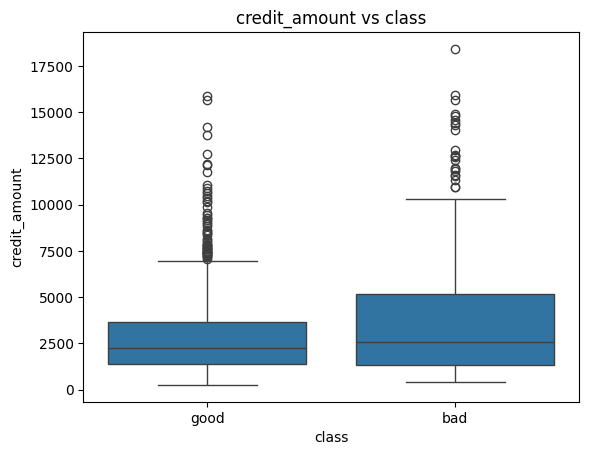

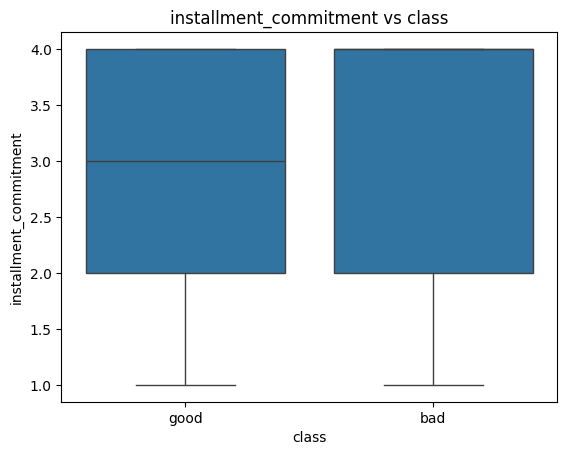

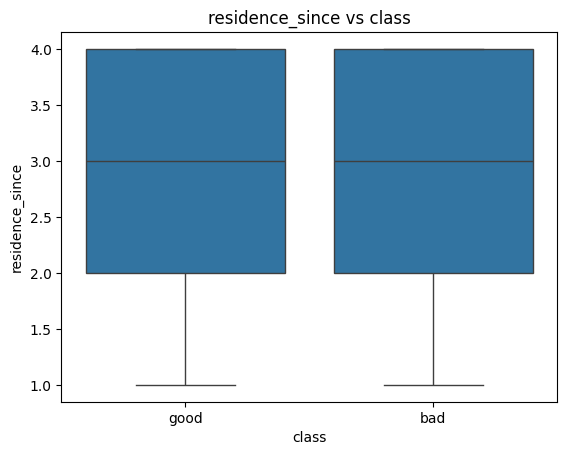

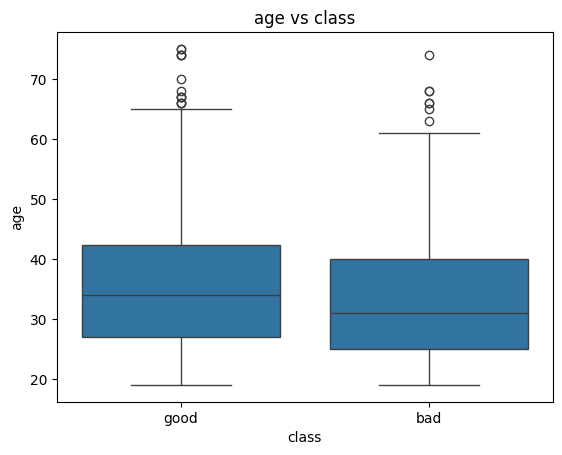

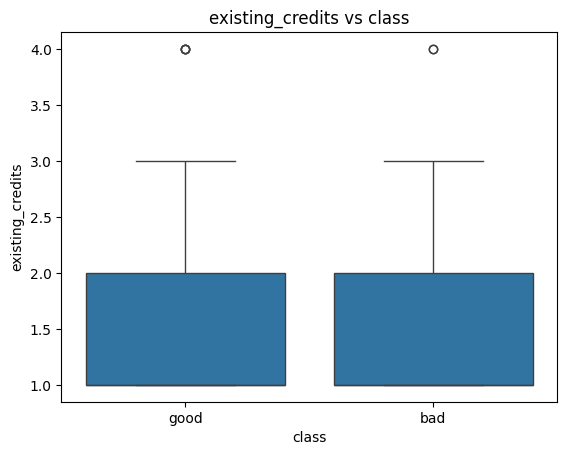

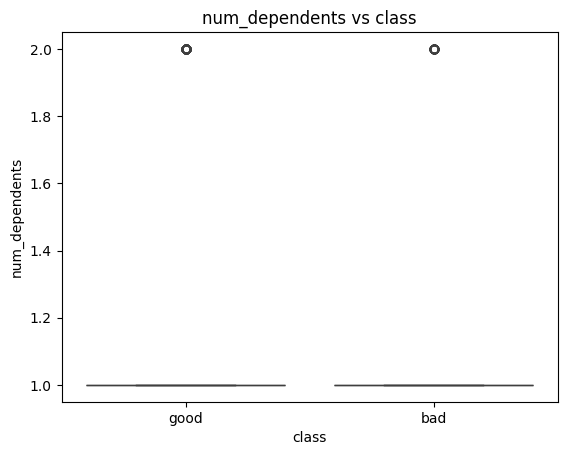

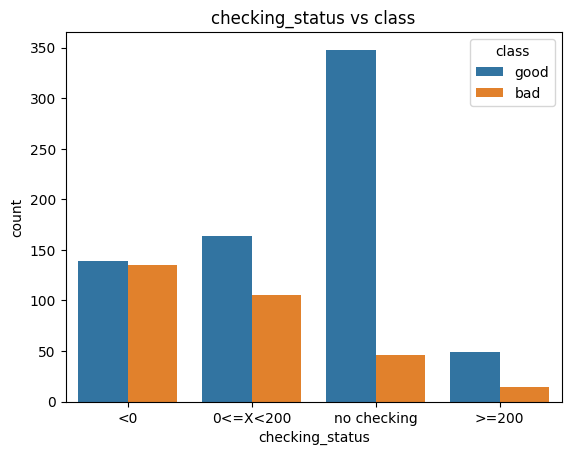

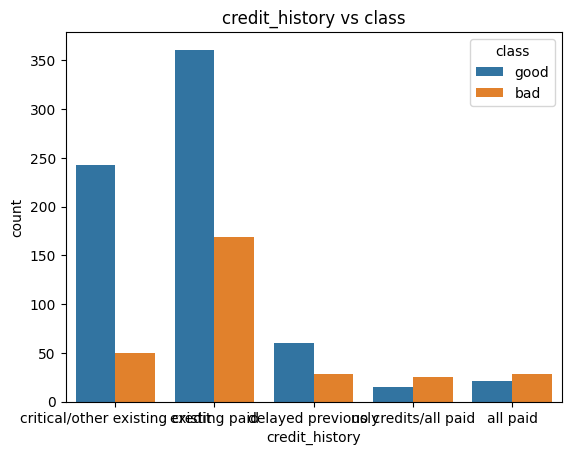

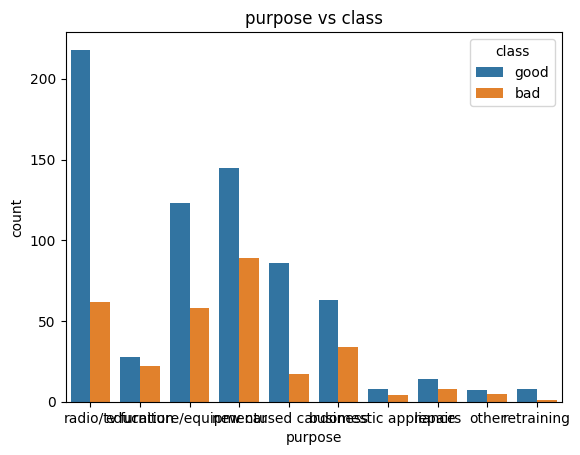

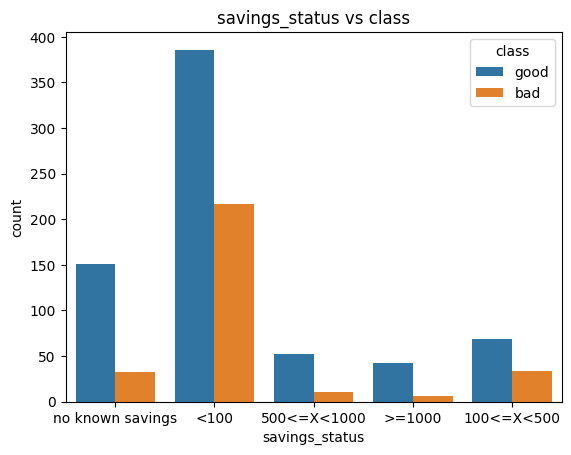

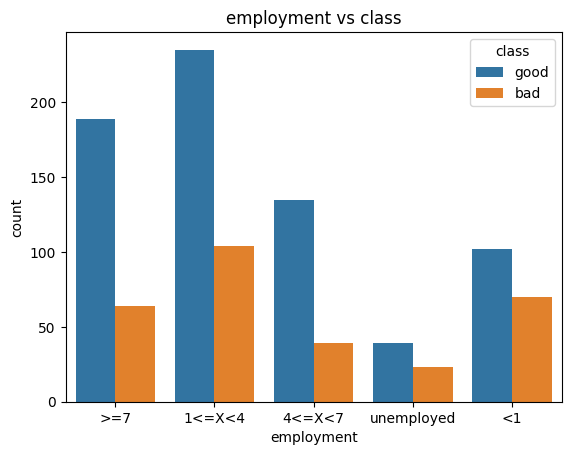

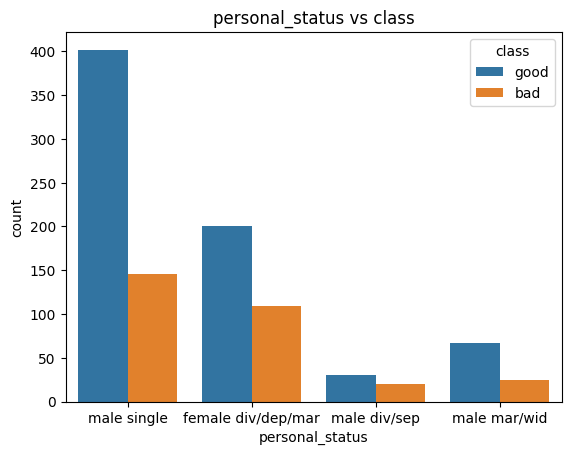

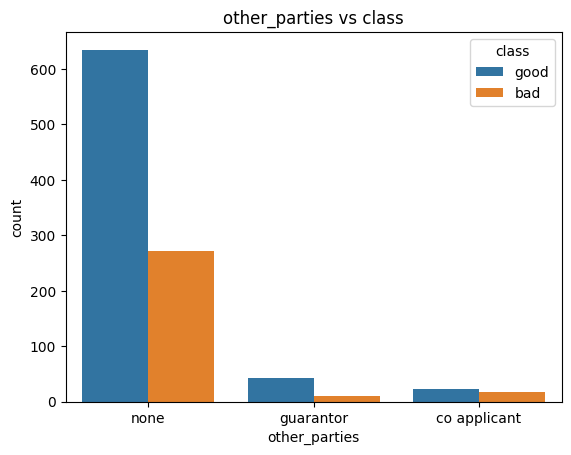

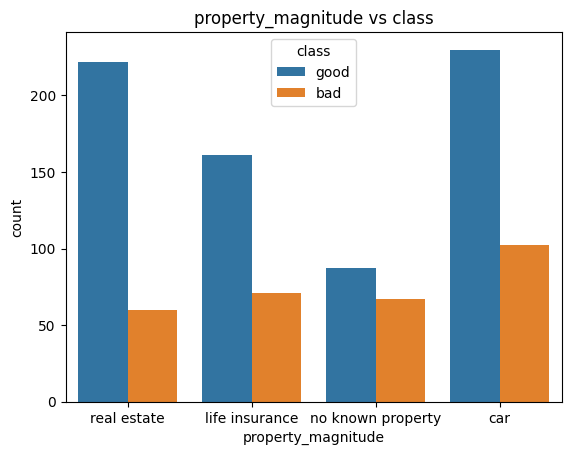

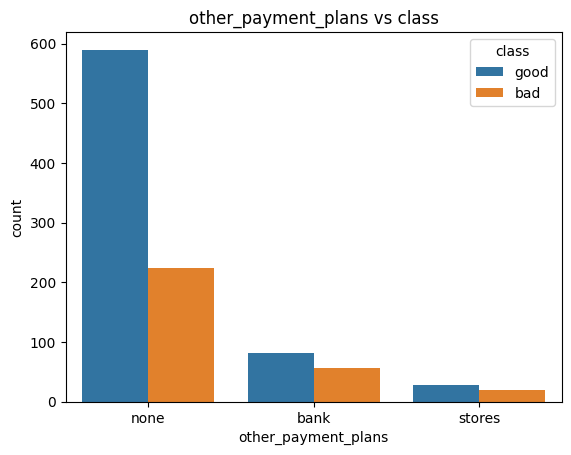

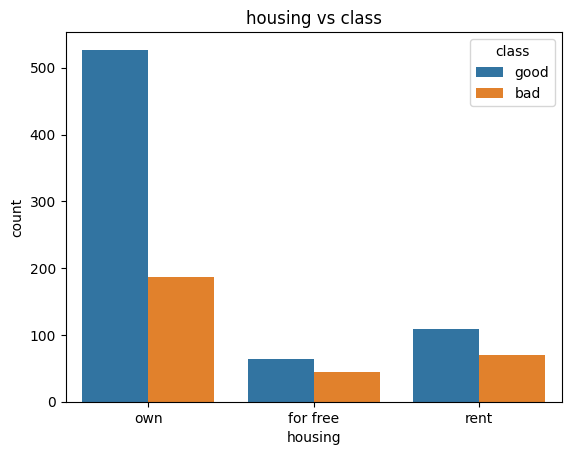

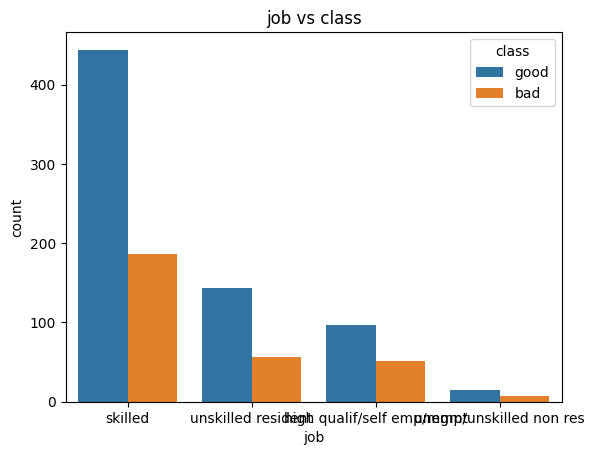

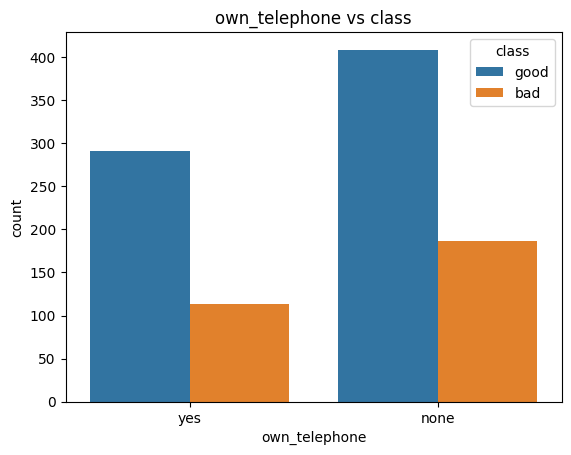

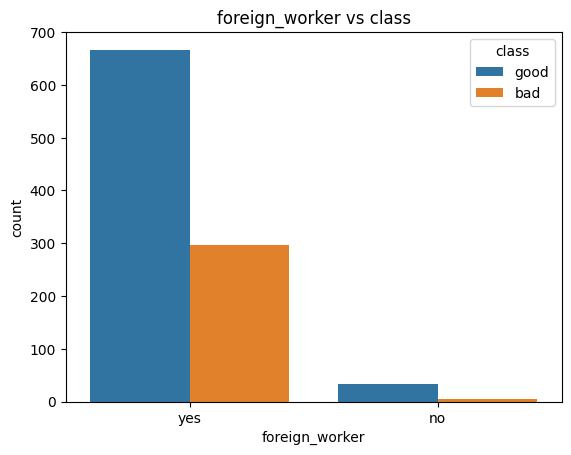

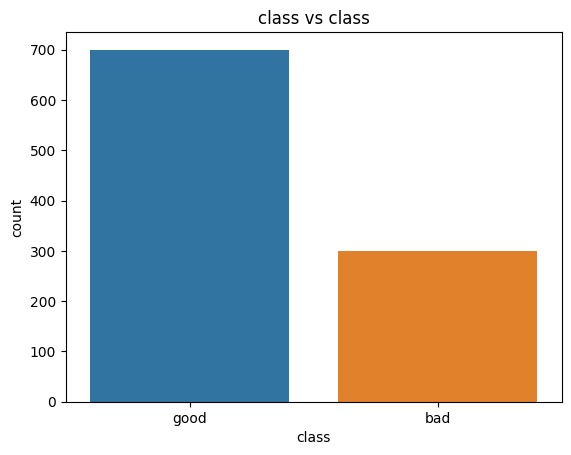

In [5]:
#Relationships with target variable
print(DIVIDER)
print("Relationship with target variable")
print(DIVIDER)
target_col = 'class'

# Separate numeric and categorical features
numeric_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(exclude='number').columns

# Numeric features -> boxplot vs class
for feature in numeric_features:
    sns.boxplot(x=target_col, y=feature, data=df)
    plt.title(f'{feature} vs {target_col}')
    plt.show()

# Categorical features -> countplot vs class
for feature in categorical_features:
    sns.countplot(x=feature, hue=target_col, data=df)
    plt.title(f'{feature} vs {target_col}')
    plt.show()

# Data Preprocessing

This section covers the preprocessing steps needed for supervised modeling in Part C.

**Tasks:**
1. Handle missing values
2. Apply transformations (log1p) to skewed features
3. Encode categorical variables
4. Scale numerical features
5. Split data into Training (70%), Validation (20%), and Test (10%) sets


## 2. Exploratory Data Analysis
Checking for missing values

In [6]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64


## 3. Preprocessing

In [7]:
# Separate features and target
target_col = 'class'
X = df.drop(columns=[target_col])

# Encode target (good/bad) to 1/0
y = LabelEncoder().fit_transform(df[target_col])

### 3.1.1 Check Skewness

In [8]:
# Check skewness of numerical columns
numerical_cols_check = df.select_dtypes(include=['number']).columns
skewness = df[numerical_cols_check].skew()
print("Skewness of numerical features:")
print(skewness.sort_values(ascending=False))

Skewness of numerical features:
credit_amount             1.949628
num_dependents            1.909445
existing_credits          1.272576
duration                  1.094184
age                       1.020739
residence_since          -0.272570
installment_commitment   -0.531348
dtype: float64


### 3.3 Encoding and Scaling

In [9]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('scaler', StandardScaler())
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Fit and transform the features
X_processed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(cat_feature_names)

# Convert to DataFrame for easier handling
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names, index=X.index)

print(f"\nProcessed feature matrix shape: {X_processed_df.shape}")
print(f"  - Numerical features: {len(numerical_cols)}")
print(f"  - One-hot encoded features: {len(cat_feature_names)}")
X_processed_df.head()


Numerical columns (7): ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Categorical columns (13): ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']

Processed feature matrix shape: (1000, 61)
  - Numerical features: 7
  - One-hot encoded features: 54


,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,...,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,-0.606621,1.627770,-0.259299,...,0.634448,-0.466933,-0.416784,0.766356,-0.149983,-0.5,-1.214598,1.214598,-0.196014,0.196014
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,1.648476,-0.614337,-0.259299,...,0.634448,-0.466933,-0.416784,0.766356,-0.149983,-0.5,0.823318,-0.823318,-0.196014,0.196014
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,-0.606621,-0.614337,-0.259299,...,0.634448,-0.466933,-0.416784,-1.304877,-0.149983,2.0,0.823318,-0.823318,-0.196014,0.196014
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,-0.606621,1.627770,-0.259299,...,-1.576173,-0.466933,-0.416784,0.766356,-0.149983,-0.5,0.823318,-0.823318,-0.196014,0.196014
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,-0.606621,1.627770,-0.259299,...,-1.576173,-0.466933,-0.416784,0.766356,-0.149983,-0.5,0.823318,-0.823318,-0.196014,0.196014


## Unsupervised Structure Check (PCA + K-Means)

PC1 variance: 6.84%
PC2 variance: 4.75%
Cumulative (PC1+PC2): 11.59%
Silhouette score (k=2 on PCA space): 0.379

Cluster composition by true class (row-normalized):
col_0         0         1
row_0                    
0      0.335277  0.664723
1      0.281583  0.718417


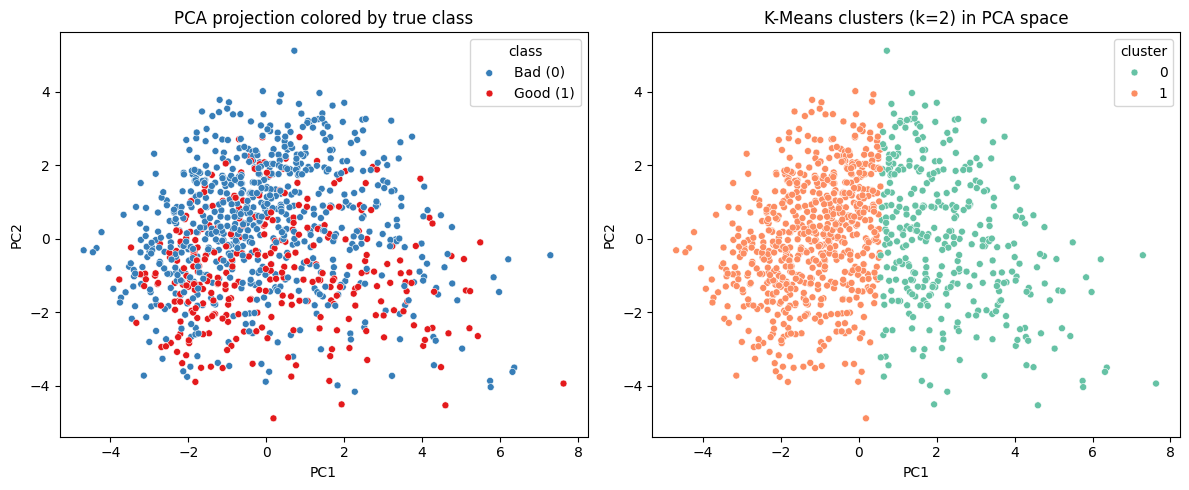

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# PCA to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed_df)
pca_explained = pca.explained_variance_ratio_
print(f"PC1 variance: {pca_explained[0]:.2%}")
print(f"PC2 variance: {pca_explained[1]:.2%}")
print(f"Cumulative (PC1+PC2): {pca_explained.sum():.2%}")

# K-Means on PCA projection
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(X_pca)
sil_score = silhouette_score(X_pca, cluster_labels)
cluster_mix = pd.crosstab(cluster_labels, y, normalize='index')
print(f"Silhouette score (k=2 on PCA space): {sil_score:.3f}")
print("\nCluster composition by true class (row-normalized):")
print(cluster_mix)

# Visualize PCA projection with labels and clusters
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['class'] = y
pca_df['cluster'] = cluster_labels

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class', palette='Set1', ax=axes[0], s=25)
axes[0].set_title('PCA projection colored by true class')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(title='class', labels=['Bad (0)', 'Good (1)'])

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='Set2', ax=axes[1], s=25)
axes[1].set_title('K-Means clusters (k=2) in PCA space')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend(title='cluster')

plt.tight_layout()
plt.show()


## 4. Data Splitting

In [11]:
# First split: 80% Train, 20% Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: split the 20% Temp into 1/2 Validation (10% total) and 1/2 Test (10% total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train set shape: {X_train.shape} ({len(X_train)/len(df):.1%})")
print(f"Validation set shape: {X_val.shape} ({len(X_val)/len(df):.1%})")
print(f"Test set shape: {X_test.shape} ({len(X_test)/len(df):.1%})")

Train set shape: (800, 61) (80.0%)
Validation set shape: (100, 61) (10.0%)
Test set shape: (100, 61) (10.0%)


# Supervised Learning: Logistic Regression

In [105]:
lambda_values = [0.001, 0.01, 0.1, 0.5, 0.8, 1, 10, 100]
log_reg_results = []

def run_log_reg(X_train_z, y_train, X_val_z, y_val, X_test_z, y_test, name):
    print(f"\n===== {name} =====")
    threshold = 0.7

    for lambda_val in lambda_values:
        model = LogisticRegression(max_iter=2000, C=lambda_val)
        model.fit(X_train_z, y_train)

        # Validation predictions
        probs_train = model.predict_proba(X_train_z)[:, 1]
        probs_val = model.predict_proba(X_val_z)[:, 1]
        y_val_pred_thresh = (probs_val >= threshold).astype(int)
        
        y_train_pred_thresh = (probs_train >= threshold).astype(int)
        train_acc = accuracy_score(y_train, y_train_pred_thresh)

        val_acc = accuracy_score(y_val, y_val_pred_thresh)
        val_f1 = f1_score(y_val, y_val_pred_thresh)
        val_roc = roc_auc_score(y_val, probs_val)
        val_precision = precision_score(y_val, y_val_pred_thresh)
        val_recall = recall_score(y_val, y_val_pred_thresh)

        # Test predictions
        probs_test = model.predict_proba(X_test_z)[:, 1]
        y_test_pred_thresh = (probs_test >= threshold).astype(int)

        test_acc = accuracy_score(y_test, y_test_pred_thresh)
        test_f1 = f1_score(y_test, y_test_pred_thresh)
        test_precision = precision_score(y_test, y_test_pred_thresh)
        test_recall = recall_score(y_test, y_test_pred_thresh)

        print(f"lambda={lambda_val:<6} | Val Acc = {val_acc:.4f} | Test Acc = {test_acc:.4f}")
        
        log_reg_results.append({
            'feature_version': name,
            'lambda': lambda_val,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'test_acc': test_acc,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall,
        })


## Z0: Original Features

In [106]:
run_log_reg(X_train, y_train, X_val, y_val, X_test, y_test, "Z0")


===== Z0 =====
lambda=0.001  | Val Acc = 0.6200 | Test Acc = 0.7000
lambda=0.01   | Val Acc = 0.6400 | Test Acc = 0.7400
lambda=0.1    | Val Acc = 0.6400 | Test Acc = 0.7100
lambda=0.5    | Val Acc = 0.6400 | Test Acc = 0.7000
lambda=0.8    | Val Acc = 0.6400 | Test Acc = 0.7000
lambda=1      | Val Acc = 0.6400 | Test Acc = 0.7000
lambda=10     | Val Acc = 0.6300 | Test Acc = 0.7000
lambda=100    | Val Acc = 0.6300 | Test Acc = 0.7000


## Z1: Squared Features

In [107]:
Z1_train = X_train.copy()
Z1_val = X_val.copy()
Z1_test = X_test.copy()

# Choose features to square
square_features = ["credit_amount", "age"]

for col in square_features:
    Z1_train[col + "_sq"] = Z1_train[col] ** 2
    Z1_val[col + "_sq"] = Z1_val[col] ** 2
    Z1_test[col + "_sq"] = Z1_test[col] ** 2

run_log_reg(Z1_train, y_train, Z1_val, y_val, Z1_test, y_test, "Z1")


===== Z1 =====
lambda=0.001  | Val Acc = 0.6500 | Test Acc = 0.7200
lambda=0.01   | Val Acc = 0.6500 | Test Acc = 0.7500
lambda=0.1    | Val Acc = 0.6500 | Test Acc = 0.7500
lambda=0.5    | Val Acc = 0.6500 | Test Acc = 0.7400
lambda=0.8    | Val Acc = 0.6300 | Test Acc = 0.7400
lambda=1      | Val Acc = 0.6300 | Test Acc = 0.7400
lambda=10     | Val Acc = 0.6300 | Test Acc = 0.7400
lambda=100    | Val Acc = 0.6300 | Test Acc = 0.7400


## Z2: Cubic Feature

In [108]:
Z2_train = X_train.copy()
Z2_val = X_val.copy()
Z2_test = X_test.copy()

cubic_features = ["duration","credit_amount","installment_commitment","residence_since", "age","existing_credits","num_dependents"] 
for col in cubic_features:
    Z2_train[col + "_cube"] = Z2_train[col] ** 3
    Z2_val[col + "_cube"] = Z2_val[col] ** 3
    Z2_test[col + "_cube"] = Z2_test[col] ** 3

run_log_reg(Z2_train, y_train, Z2_val, y_val, Z2_test, y_test, "Z2")


===== Z2 =====
lambda=0.001  | Val Acc = 0.6400 | Test Acc = 0.7100
lambda=0.01   | Val Acc = 0.6700 | Test Acc = 0.7300
lambda=0.1    | Val Acc = 0.6500 | Test Acc = 0.6700
lambda=0.5    | Val Acc = 0.6500 | Test Acc = 0.6600
lambda=0.8    | Val Acc = 0.6500 | Test Acc = 0.6600
lambda=1      | Val Acc = 0.6500 | Test Acc = 0.6600
lambda=10     | Val Acc = 0.6500 | Test Acc = 0.6600
lambda=100    | Val Acc = 0.6500 | Test Acc = 0.6500


## Z3: Quartic Feature via Products

In [109]:
Z3_train = X_train.copy()
Z3_val = X_val.copy()
Z3_test = X_test.copy()

f1 = "duration"
f2 = "credit_amount"
f3 = "age"
f4 = "installment_commitment"

Z3_train[f1 + "_x_" + f2 + "_x_" + f3 + "_x_" + f4] = Z3_train[f1] * Z3_train[f2] * Z3_train[f3] * Z3_train[f4]
Z3_val[f1 + "_x_" + f2 + "_x_" + f3  + "_x_" + f4] = Z3_val[f1] * Z3_val[f2] * Z3_val[f3] * Z3_val[f4]
Z3_test[f1 + "_x_" + f2 + "_x_" + f3  + "_x_" + f4] = Z3_test[f1] * Z3_test[f2] * Z3_test[f3] * Z3_test[f4]

run_log_reg(Z3_train, y_train, Z3_val, y_val, Z3_test, y_test, "Z3")


===== Z3 =====
lambda=0.001  | Val Acc = 0.6200 | Test Acc = 0.7000
lambda=0.01   | Val Acc = 0.6500 | Test Acc = 0.7400
lambda=0.1    | Val Acc = 0.6300 | Test Acc = 0.7100
lambda=0.5    | Val Acc = 0.6200 | Test Acc = 0.7000
lambda=0.8    | Val Acc = 0.6300 | Test Acc = 0.7000
lambda=1      | Val Acc = 0.6300 | Test Acc = 0.7000
lambda=10     | Val Acc = 0.6300 | Test Acc = 0.7000
lambda=100    | Val Acc = 0.6300 | Test Acc = 0.7000


## Logistic Regression Results

In [110]:
log_results_df = pd.DataFrame(log_reg_results).sort_values(['feature_version', 'lambda']).reset_index(drop=True)

# Results table
cols_to_show = [
    'feature_version', 'lambda', 'train_acc',
    'val_acc', 'val_f1', 'val_precision', 'val_recall',
    'test_acc', 'test_f1', 'test_precision', 'test_recall'
]
print("Logistic Regression results:\n")
print(log_results_df[cols_to_show].to_string(index=False))

log_results_df.to_csv('logreg_results.csv', index=False)
print("Saved as 'logreg_results.csv'")

Logistic Regression results:

feature_version  lambda  train_acc  val_acc   val_f1  val_precision  val_recall  test_acc  test_f1  test_precision  test_recall
             Z0   0.001    0.72375     0.62 0.672414       0.847826    0.557143      0.70 0.758065        0.870370     0.671429
             Z0   0.010    0.75625     0.64 0.700000       0.840000    0.600000      0.74 0.800000        0.866667     0.742857
             Z0   0.100    0.75250     0.64 0.714286       0.803571    0.642857      0.71 0.775194        0.847458     0.714286
             Z0   0.500    0.75250     0.64 0.714286       0.803571    0.642857      0.70 0.765625        0.844828     0.700000
             Z0   0.800    0.75375     0.64 0.714286       0.803571    0.642857      0.70 0.765625        0.844828     0.700000
             Z0   1.000    0.75375     0.64 0.714286       0.803571    0.642857      0.70 0.765625        0.844828     0.700000
             Z0  10.000    0.75625     0.63 0.704000       0.800000    0.6

## Logistic Regression Visualization

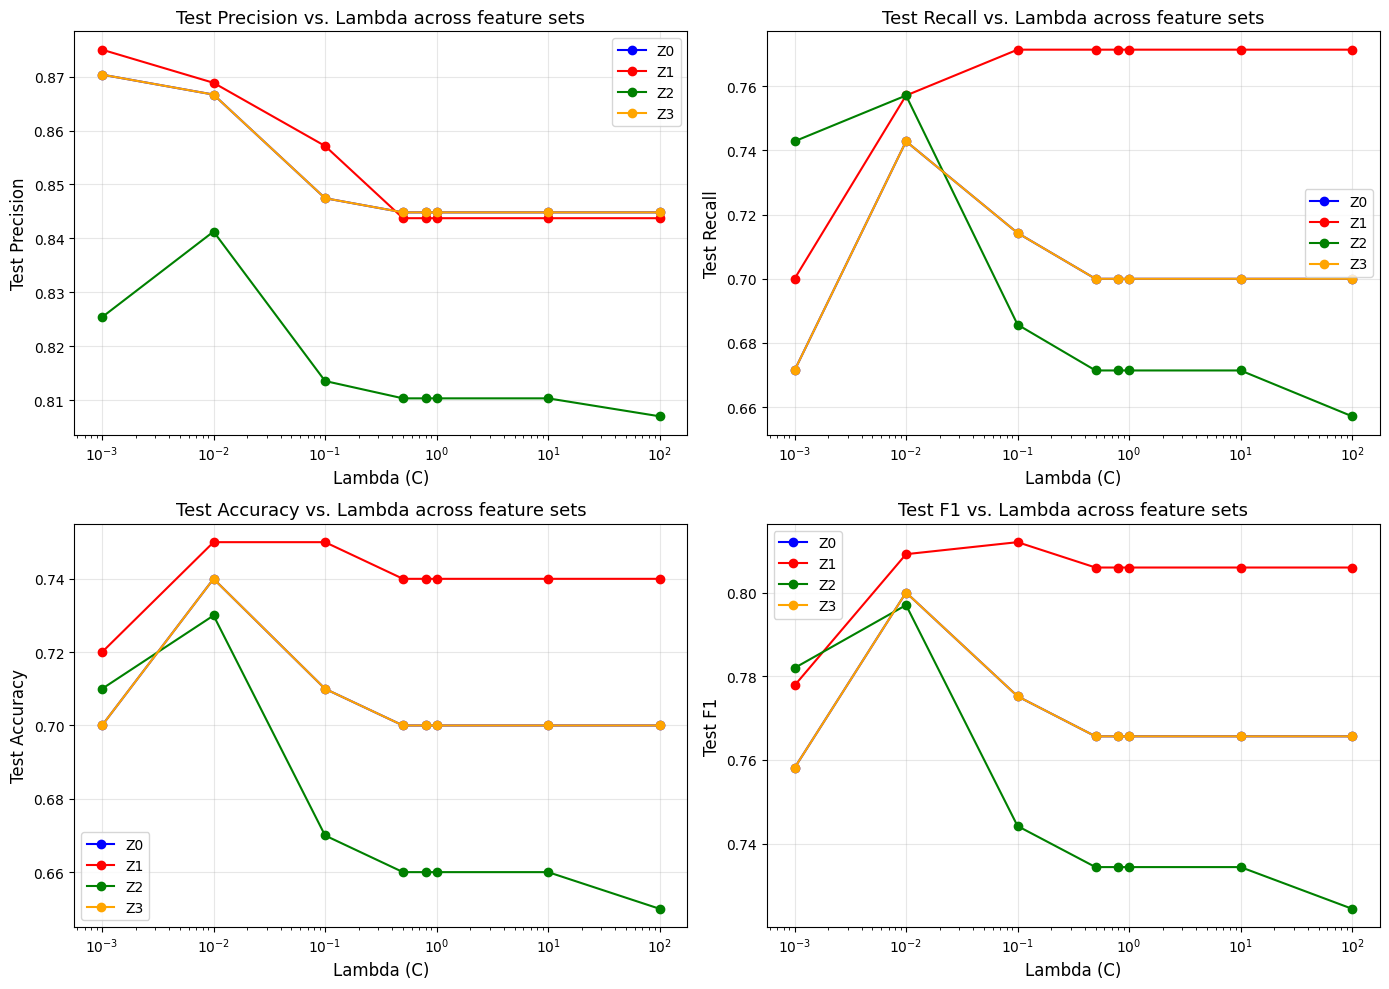

<Figure size 640x480 with 0 Axes>

Saved plot as 'logreg_metric_vs_lambda.png'
Test summary by feature set (mean values):
                  test_acc  test_precision  test_recall  test_f1
feature_version                                                 
Interactions          0.73          0.7363       0.9857   0.8323
Original              0.77          0.7765       0.9429   0.8516
Polynomial (d=2)      0.73          0.7416       0.9714   0.8302
Square Root           0.76          0.7738       0.9429   0.8442


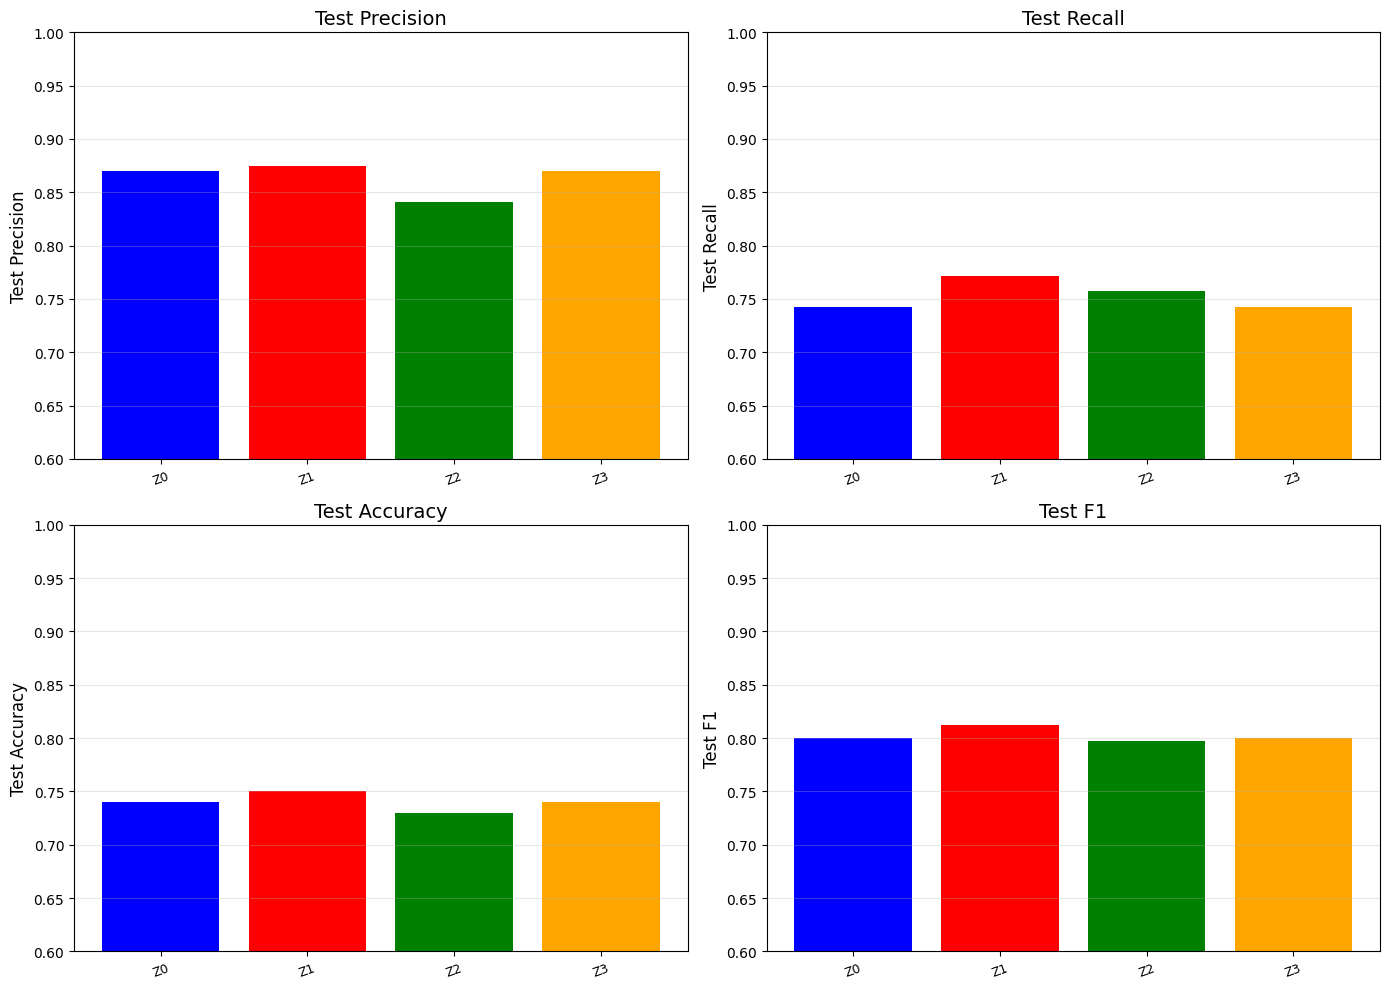

Saved bar chart as 'logreg_transformation_metric_comparison.png'


In [111]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 

metrics = [
    ('test_precision', 'Test Precision'),
    ('test_recall', 'Test Recall'),
    ('test_acc', 'Test Accuracy'),
    ('test_f1', 'Test F1')
]

colors = {'Z0': 'blue', 'Z1': 'red', 
          'Z2': 'green', 'Z3': 'orange'}

for ax, (metric, title) in zip(axes, metrics):
    for feat_name in log_results_df['feature_version'].unique():
        data = log_results_df[log_results_df['feature_version'] == feat_name].sort_values('lambda')
        ax.plot(data['lambda'], data[metric], marker='o', label=feat_name, color=colors.get(feat_name, None))

    ax.set_xscale('log')
    ax.set_xlabel('Lambda (C)', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} vs. Lambda across feature sets', fontsize=13)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.savefig('logreg_metric_vs_lambda.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved plot as 'logreg_metric_vs_lambda.png'")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['blue', 'red', 'green', 'orange']

summary_max = (
    log_results_df.groupby('feature_version')[['test_acc', 'test_precision', 'test_recall', 'test_f1']]
    .max()
    .round(4)
)

print("Test summary by feature set (mean values):")
print(summary)

for ax, (metric, title) in zip(axes, metrics):
    means = summary_max[metric]

    ax.bar(means.index, means.values, color=colors)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(title, fontsize=14)

    # Set y-axis from 0.60 to 0.90
    ax.set_ylim(0.60, 0.90)
    ax.set_yticks(np.arange(0.60, 1.01, 0.05))

    ax.tick_params(axis='x', rotation=20, labelsize=9)
    ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('logreg_transformation_metric_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved bar chart as 'logreg_transformation_metric_comparison.png'")


# Supervised Learning: K-Nearest Neighbors (KNN)

## KNN.1 Import Required Libraries

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

## KNN.2 Create Feature Transformations

In [48]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_interact = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_train_base = np.asarray(X_train)
X_val_base = np.asarray(X_val)
X_test_base = np.asarray(X_test)


def scale_after_transform(X_tr, X_v, X_te):
    scaler = StandardScaler()
    return scaler.fit_transform(X_tr), scaler.transform(X_v), scaler.transform(X_te)

X_train_poly_raw = poly.fit_transform(X_train_base)
X_val_poly_raw = poly.transform(X_val_base)
X_test_poly_raw = poly.transform(X_test_base)
X_train_poly, X_val_poly, X_test_poly = scale_after_transform(
    X_train_poly_raw, X_val_poly_raw, X_test_poly_raw
)

X_train_interact_raw = poly_interact.fit_transform(X_train_base)
X_val_interact_raw = poly_interact.transform(X_val_base)
X_test_interact_raw = poly_interact.transform(X_test_base)
X_train_interact, X_val_interact, X_test_interact = scale_after_transform(
    X_train_interact_raw, X_val_interact_raw, X_test_interact_raw
)

shift = X_train_base.min()
X_train_sqrt_raw = np.sqrt(X_train_base - shift + 1)
X_val_sqrt_raw = np.sqrt(X_val_base - shift + 1)
X_test_sqrt_raw = np.sqrt(X_test_base - shift + 1)
X_train_sqrt, X_val_sqrt, X_test_sqrt = scale_after_transform(
    X_train_sqrt_raw, X_val_sqrt_raw, X_test_sqrt_raw
)

feature_sets = {
    "Original": (X_train_base, X_val_base, X_test_base),
    "Polynomial (d=2)": (X_train_poly, X_val_poly, X_test_poly),
    "Interactions": (X_train_interact, X_val_interact, X_test_interact),
    "Square Root": (X_train_sqrt, X_val_sqrt, X_test_sqrt),
}

for name, (Xt, Xv, Xte) in feature_sets.items():
    print(f"{name}: train {Xt.shape}, val {Xv.shape}, test {Xte.shape}")

Original: train (800, 61), val (100, 61), test (100, 61)
Polynomial (d=2): train (800, 1952), val (100, 1952), test (100, 1952)
Interactions: train (800, 1891), val (100, 1891), test (100, 1891)
Square Root: train (800, 61), val (100, 61), test (100, 61)


## KNN.3 Define Regularization Parameter Values

In [49]:
k_values_to_test = [3, 5, 7, 9, 11, 15]

print(f"K values: {k_values_to_test}")
print("Models to evaluate: 4 feature sets × 6 K values = 24")

K values: [3, 5, 7, 9, 11, 15]
Models to evaluate: 4 feature sets × 6 K values = 24


## KNN.4 Train and Evaluate All Model Combinations

In [57]:
import time

knn_results = []
for feat_name, (X_tr, X_v, X_te) in feature_sets.items():
    for k in k_values_to_test:
        start = time.perf_counter()
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_tr, y_train)
        training_time = time.perf_counter() - start

        # Predictions
        y_train_pred = knn.predict(X_tr)
        y_val_pred = knn.predict(X_v)
        y_test_pred = knn.predict(X_te)

        y_train_proba = knn.predict_proba(X_tr)[:, 1]
        y_val_proba = knn.predict_proba(X_v)[:, 1]
        y_test_proba = knn.predict_proba(X_te)[:, 1]

        knn_results.append({
            'feature_version': feat_name,
            'k': k,
            'n_features': X_tr.shape[1],
            
            'train_acc': accuracy_score(y_train, y_train_pred),
            'train_precision': precision_score(y_train, y_train_pred),
            'train_recall': recall_score(y_train, y_train_pred),
            'train_f1': f1_score(y_train, y_train_pred),
            
            'val_acc': accuracy_score(y_val, y_val_pred),
            'val_precision': precision_score(y_val, y_val_pred),
            'val_recall': recall_score(y_val, y_val_pred),
            'val_f1': f1_score(y_val, y_val_pred),
            
            'test_acc': accuracy_score(y_test, y_test_pred),
            'test_precision': precision_score(y_test, y_test_pred),
            'test_recall': recall_score(y_test, y_test_pred),
            'test_f1': f1_score(y_test, y_test_pred),
        })

knn_results_df = pd.DataFrame(knn_results).sort_values(['feature_version', 'k']).reset_index(drop=True)
results_df = knn_results_df.copy()

best_model_config = knn_results_df.loc[knn_results_df['val_f1'].idxmax()]
print(f"Best validation F1: {best_model_config['val_f1']:.4f} using {best_model_config['feature_version']} with k={int(best_model_config['k'])}")


Best validation F1: 0.8428 using Original with k=15


## KNN.5 Complete Results Table

In [93]:
cols_to_show = [
    'feature_version', 'k', 'n_features', 'train_acc',
    'val_acc', 'val_f1', 'val_precision', 'val_recall',
    'test_acc', 'test_f1', 'test_precision', 'test_recall'
]
print("KNN results (all 24 models):\n")
print(knn_results_df[cols_to_show].to_string(index=False))

knn_results_df.to_csv('knn_results.csv', index=False)
print("Saved as 'knn_results.csv'")

KNN results (all 24 models):

 feature_version  k  n_features  train_acc  val_acc   val_f1  val_precision  val_recall  test_acc  test_f1  test_precision  test_recall
    Interactions  3        1891    0.83250     0.64 0.763158       0.707317    0.828571      0.72 0.825000        0.733333     0.942857
    Interactions  5        1891    0.76875     0.69 0.805031       0.719101    0.914286      0.73 0.832298        0.736264     0.957143
    Interactions  7        1891    0.76000     0.69 0.809816       0.709677    0.942857      0.71 0.824242        0.715789     0.971429
    Interactions  9        1891    0.74250     0.71 0.822086       0.720430    0.957143      0.70 0.819277        0.708333     0.971429
    Interactions 11        1891    0.72500     0.71 0.826347       0.711340    0.985714      0.68 0.809524        0.693878     0.971429
    Interactions 15        1891    0.72375     0.70 0.821429       0.704082    0.985714      0.69 0.816568        0.696970     0.985714
        Original  

## KNN.6 Visualize Performance vs Feature Transformations and K

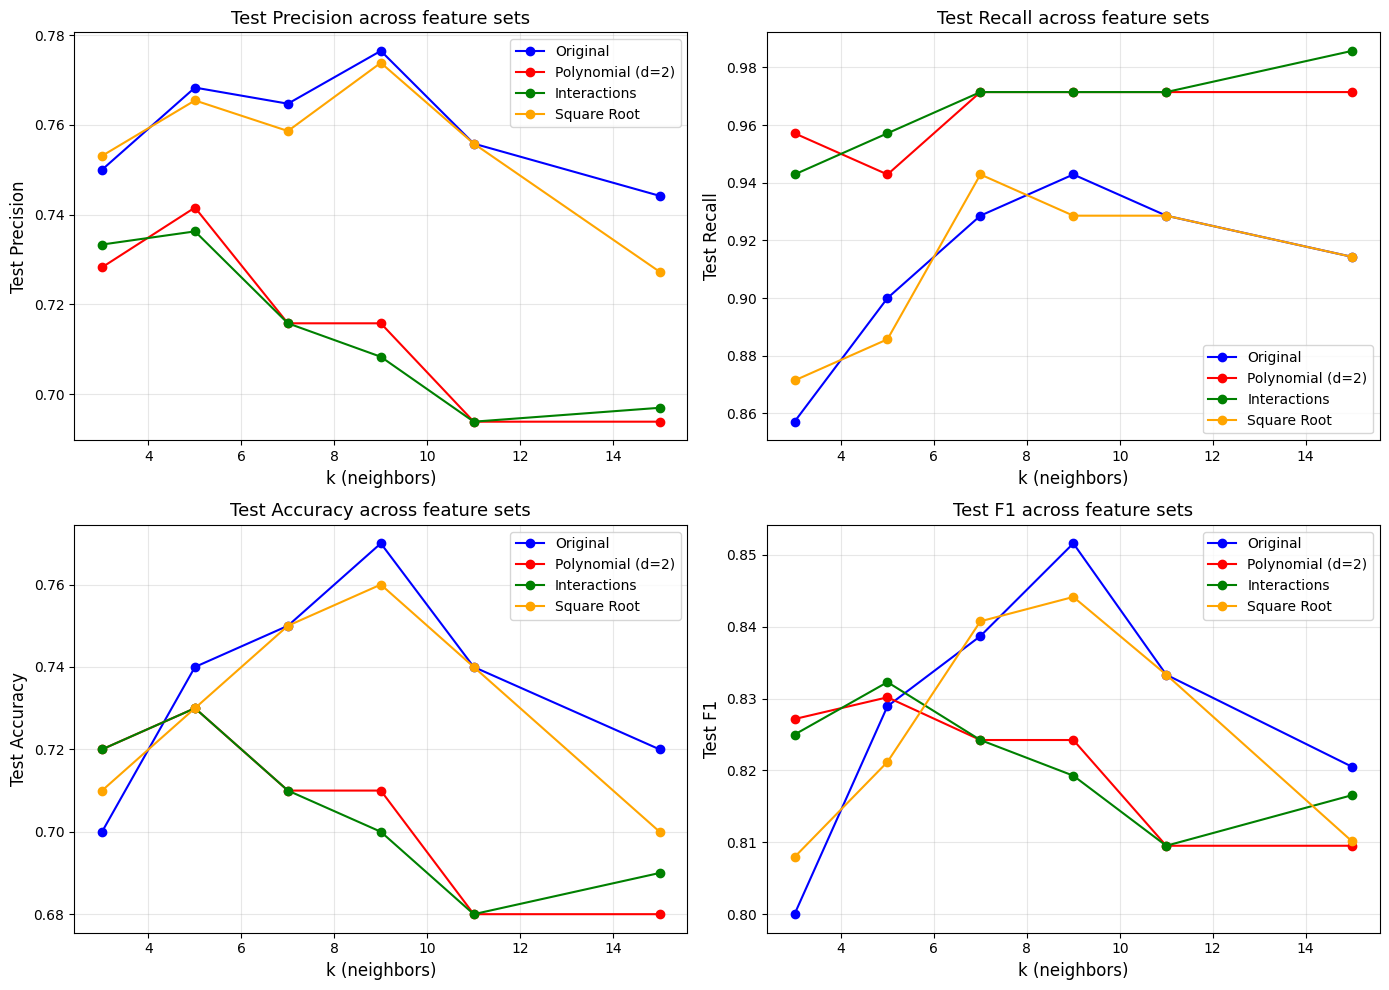

Saved plot as 'knn_metric_vs_k.png'


In [59]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 

metrics = [
    ('test_precision', 'Test Precision'),
    ('test_recall', 'Test Recall'),
    ('test_acc', 'Test Accuracy'),
    ('test_f1', 'Test F1')
]
colors = {'Original': 'blue', 'Polynomial (d=2)': 'red', 'Interactions': 'green', 'Square Root': 'orange'}

for ax, (metric, title) in zip(axes, metrics):
    for feat_name in feature_sets.keys():
        data = knn_results_df[knn_results_df['feature_version'] == feat_name].sort_values('k')
        ax.plot(data['k'], data[metric], marker='o', label=feat_name, color=colors.get(feat_name, None))
    ax.set_xlabel('k (neighbors)', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} across feature sets', fontsize=13)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('knn_metric_vs_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved plot as 'knn_metric_vs_k.png'")

## KNN.7 Compare Performance Across Feature Transformations

Test summary by feature set (max values):
                  test_acc  test_precision  test_recall  test_f1
feature_version                                                 
Interactions          0.73          0.7363       0.9857   0.8323
Original              0.77          0.7765       0.9429   0.8516
Polynomial (d=2)      0.73          0.7416       0.9714   0.8302
Square Root           0.76          0.7738       0.9429   0.8442


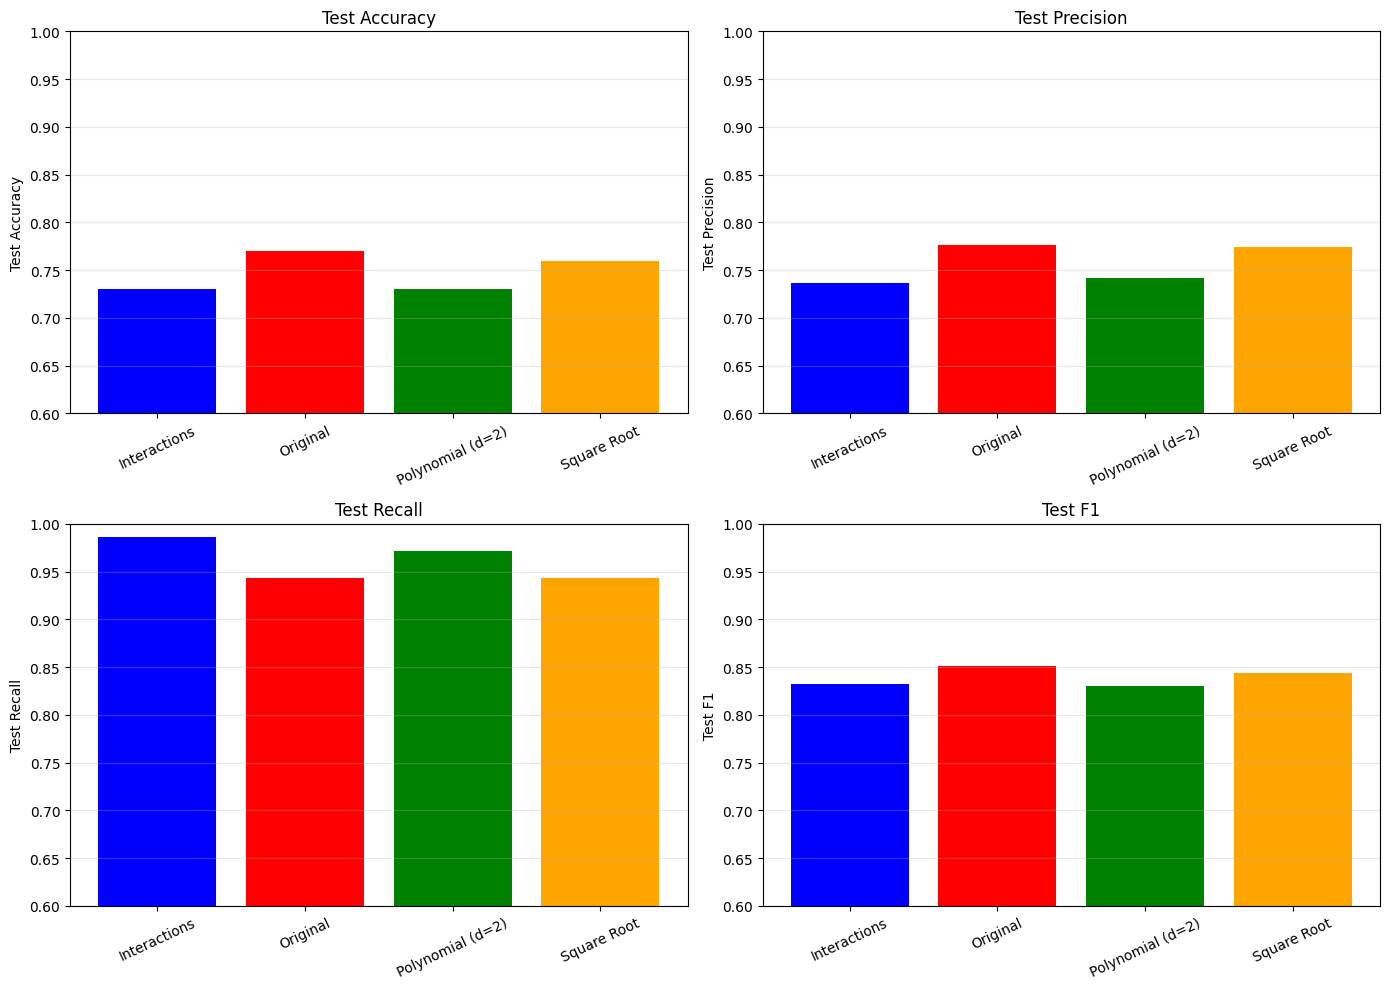

Saved 'knn_test_metric_comparison.png'


In [87]:
summary = (
    knn_results_df
    .groupby('feature_version')[['test_acc', 'test_precision', 'test_recall', 'test_f1']]
    .max()        # or .mean() depending on what you want — you said “best model”
    .round(4)
)
print("Test summary by feature set (max values):")
print(summary)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics = [
    ('test_acc', 'Test Accuracy'),
    ('test_precision', 'Test Precision'),
    ('test_recall', 'Test Recall'),
    ('test_f1', 'Test F1')
]

colors = ['blue', 'red', 'green', 'orange']

for ax, (metric, title) in zip(axes, metrics):
    values = summary[metric]

    ax.bar(values.index, values.values, color=colors)
    ax.set_ylabel(title)
    ax.set_title(title)

    ax.set_ylim(0.60, 0.90)
    ax.set_yticks(np.arange(0.60, 1.01, 0.05))

    ax.tick_params(axis='x', rotation=25)
    ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('knn_test_metric_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved 'knn_test_metric_comparison.png'")


# Supervised Learning: Neural Networks

## NN.1 Import Required Libraries

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cpu')

## NN.2 Define Neural Network Architecture

In [62]:
class CreditRiskNN(nn.Module):
    def __init__(self, input_dim):
        super(CreditRiskNN, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

test_model = CreditRiskNN(61)
print("Model architecture defined successfully.")
print(f"\nModel structure:")
print(test_model)

# Count parameters
total_params = sum(p.numel() for p in test_model.parameters())
trainable_params = sum(p.numel() for p in test_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model architecture defined successfully.

Model structure:
CreditRiskNN(
  (layer1): Linear(in_features=61, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 18,305
Trainable parameters: 18,305


## NN.3 Define Training Function

In [69]:
def train_nn_model(X_train, y_train, X_val, y_val, weight_decay=0.0, 
                   epochs=50, batch_size=32, patience=5):
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values if hasattr(y_train, 'values') else y_train).reshape(-1, 1).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1).to(device)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model = CreditRiskNN(X_train.shape[1]).to(device)
    
    # Loss and optimizer (weight_decay is L2 regularization)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    start_time = time.time()
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
            predictions = (outputs >= 0.5).float()
            train_correct += (predictions == batch_y).sum().item()
            train_total += batch_y.size(0)
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_predictions = (val_outputs >= 0.5).float()
            val_correct = (val_predictions == y_val_tensor).sum().item()
 
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        val_acc = val_correct / len(y_val)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                model.load_state_dict(best_model_state)
                break
    
    train_time = time.time() - start_time
    
    return model, history, train_time

print("Training function defined.")

Training function defined.


## NN.4 Define Regularization Parameter Values

In [70]:
weight_decay_values = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]

## NN.5 Train and Evaluate All Model Combinations

In [71]:
nn_all_results = []

for feat_name, (X_tr, X_v, X_te) in feature_sets.items():
    for wd in weight_decay_values:
        model, history, train_time = train_nn_model(
            X_tr, y_train, X_v, y_val,
            weight_decay=wd,
            epochs=200,
            batch_size=32,
            patience=5
        )

        model.eval()
        with torch.no_grad():
            y_train_pred_proba = model(torch.FloatTensor(X_tr).to(device)).cpu().numpy().flatten()
            y_val_pred_proba = model(torch.FloatTensor(X_v).to(device)).cpu().numpy().flatten()
            y_test_pred_proba = model(torch.FloatTensor(X_te).to(device)).cpu().numpy().flatten()

        y_train_pred = (y_train_pred_proba > 0.7).astype(int)
        y_val_pred = (y_val_pred_proba > 0.7).astype(int)
        y_test_pred = (y_test_pred_proba > 0.7).astype(int)

        val_f1 = f1_score(y_val, y_val_pred)
        n_epochs = len(history['train_loss'])

        nn_all_results.append({
            'feature_version': feat_name,
            'weight_decay': wd,
            'n_features': X_tr.shape[1],
            'n_epochs': n_epochs,
            'train_acc': accuracy_score(y_train, y_train_pred),
            'val_acc': accuracy_score(y_val, y_val_pred),
            'test_acc': accuracy_score(y_test, y_test_pred),
            'val_precision': precision_score(y_val, y_val_pred),
            'val_recall': recall_score(y_val, y_val_pred),
            'val_f1': val_f1,
            'test_precision': precision_score(y_test, y_test_pred),
            'test_recall': recall_score(y_test, y_test_pred),
            'test_f1': f1_score(y_test, y_test_pred),
            'training_time': train_time,
            'final_train_loss': history['train_loss'][-1],
            'final_val_loss': history['val_loss'][-1]
        })

nn_all_results_df = pd.DataFrame(nn_all_results)
print(f"Completed {len(nn_all_results_df)} neural network models.")

Completed 24 neural network models.


## NN.6 Complete Results Table

In [91]:
cols_to_show = [
    'feature_version', 'weight_decay', 'n_features', 'n_epochs',
    'train_acc', 'val_acc', 'val_f1', 'test_acc', 'test_precision', 'test_recall', 'test_f1'
]
print("Neural network results (all combinations):\n")
print(nn_all_results_df[cols_to_show].to_string(index=False))

nn_all_results_df.to_csv('nn_results.csv', index=False)

Neural network results (all combinations):

 feature_version  weight_decay  n_features  n_epochs  train_acc  val_acc   val_f1  test_acc  test_precision  test_recall  test_f1
        Original        0.0000          61         8    0.93000     0.66 0.750000      0.72        0.818182     0.771429 0.794118
        Original        0.0001          61         8    0.89625     0.66 0.750000      0.74        0.854839     0.757143 0.803030
        Original        0.0010          61         8    0.87750     0.63 0.704000      0.74        0.879310     0.728571 0.796875
        Original        0.0100          61         8    0.84875     0.61 0.682927      0.68        0.851852     0.657143 0.741935
        Original        0.1000          61       106    0.30000     0.30 0.000000      0.30        0.000000     0.000000 0.000000
        Original        1.0000          61        28    0.30000     0.30 0.000000      0.30        0.000000     0.000000 0.000000
Polynomial (d=2)        0.0000        1952    

## NN.7 Visualize Performance vs Feature Transformations and Weight Decay

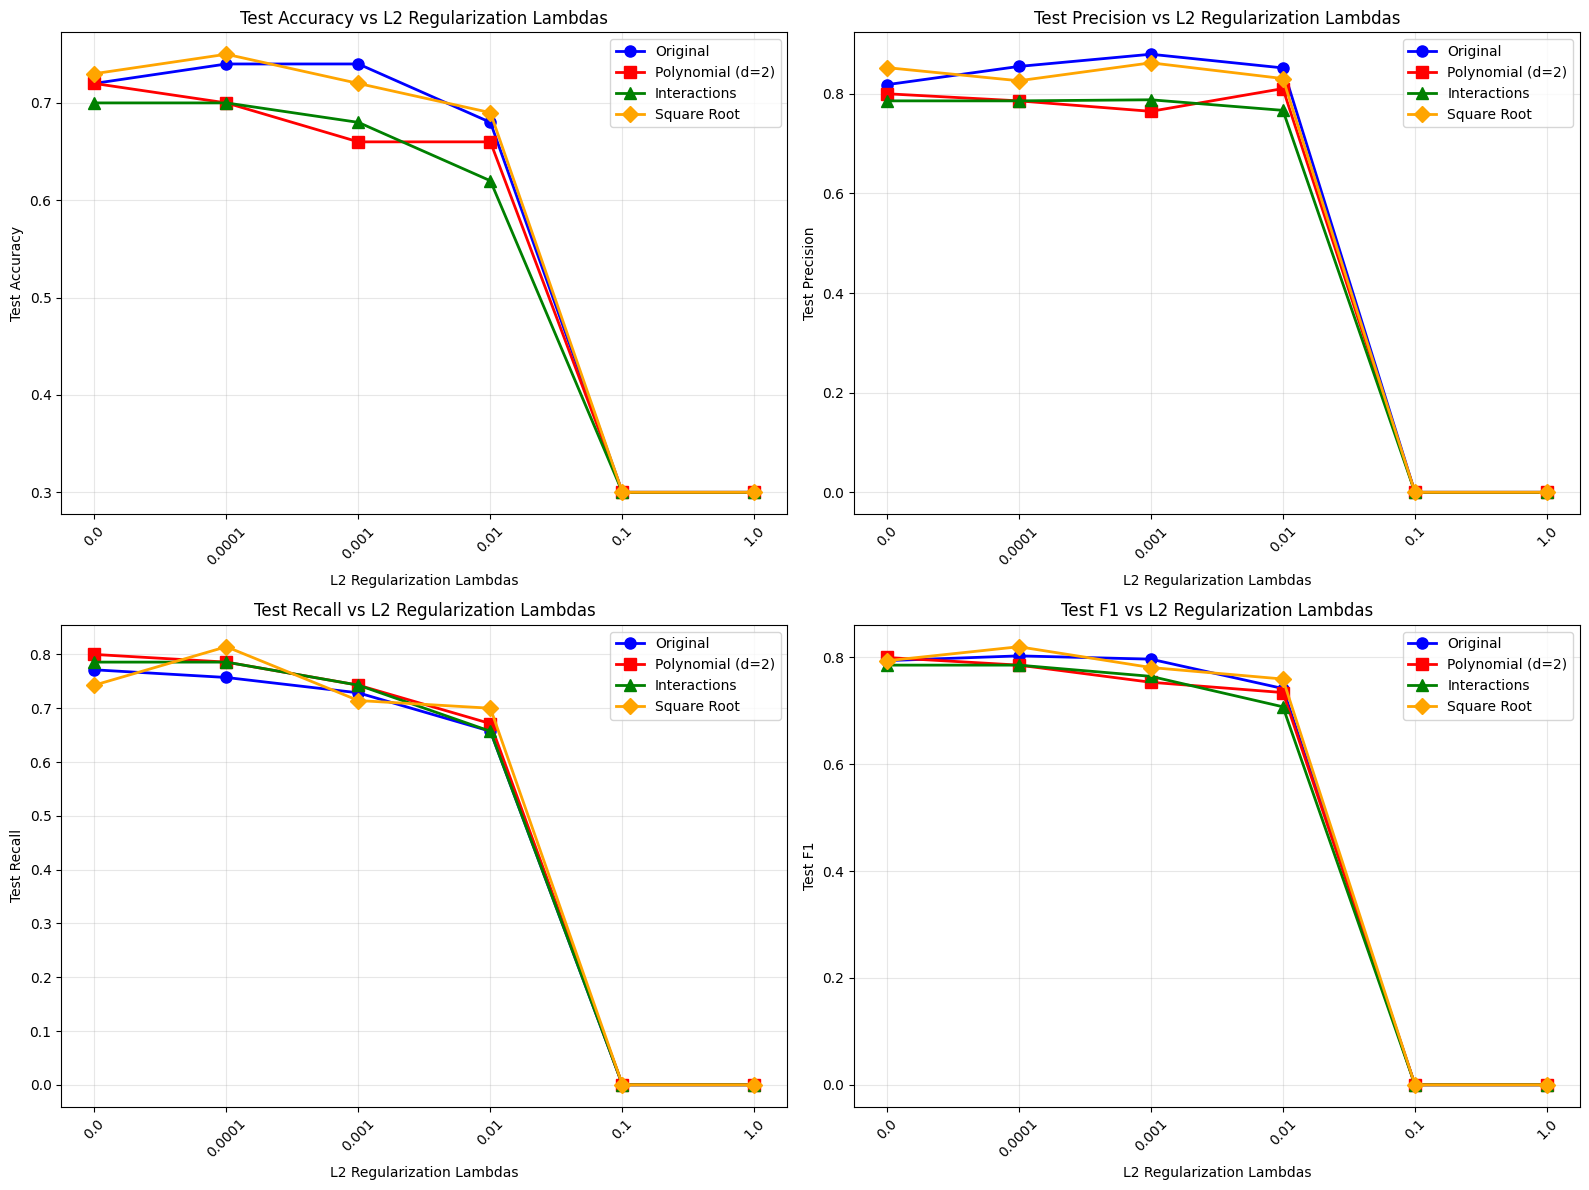

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics = [
    ('test_acc', 'Test Accuracy'),
    ('test_precision', 'Test Precision'),
    ('test_recall', 'Test Recall'),
    ('test_f1', 'Test F1')
]

colors = {'Original': 'blue', 'Polynomial (d=2)': 'red',
          'Interactions': 'green', 'Square Root': 'orange'}

markers = {'Original': 'o', 'Polynomial (d=2)': 's',
           'Interactions': '^', 'Square Root': 'D'}

wd_labels = [str(wd) for wd in weight_decay_values]

for (metric, title), ax in zip(metrics, axes):
    for feat_name in nn_all_results_df['feature_version'].unique():
        data = nn_all_results_df[nn_all_results_df['feature_version'] == feat_name] \
               .sort_values('weight_decay')

        ax.plot(range(len(weight_decay_values)), data[metric],
                marker=markers[feat_name], color=colors[feat_name],
                linewidth=2, markersize=8, label=feat_name)

    ax.set_xlabel('L2 Regularization Lambdas')
    ax.set_ylabel(title)
    ax.set_title(f'{title} vs L2 Regularization Lambdas')
    ax.set_xticks(range(len(weight_decay_values)))
    ax.set_xticklabels(wd_labels, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Neural Network Test summary by feature set (max values):
                  test_acc  test_precision  test_recall  test_f1
feature_version                                                 
Interactions          0.70          0.7879       0.7857   0.7857
Original              0.74          0.8793       0.7714   0.8030
Polynomial (d=2)      0.72          0.8103       0.8000   0.8000
Square Root           0.75          0.8621       0.8143   0.8201


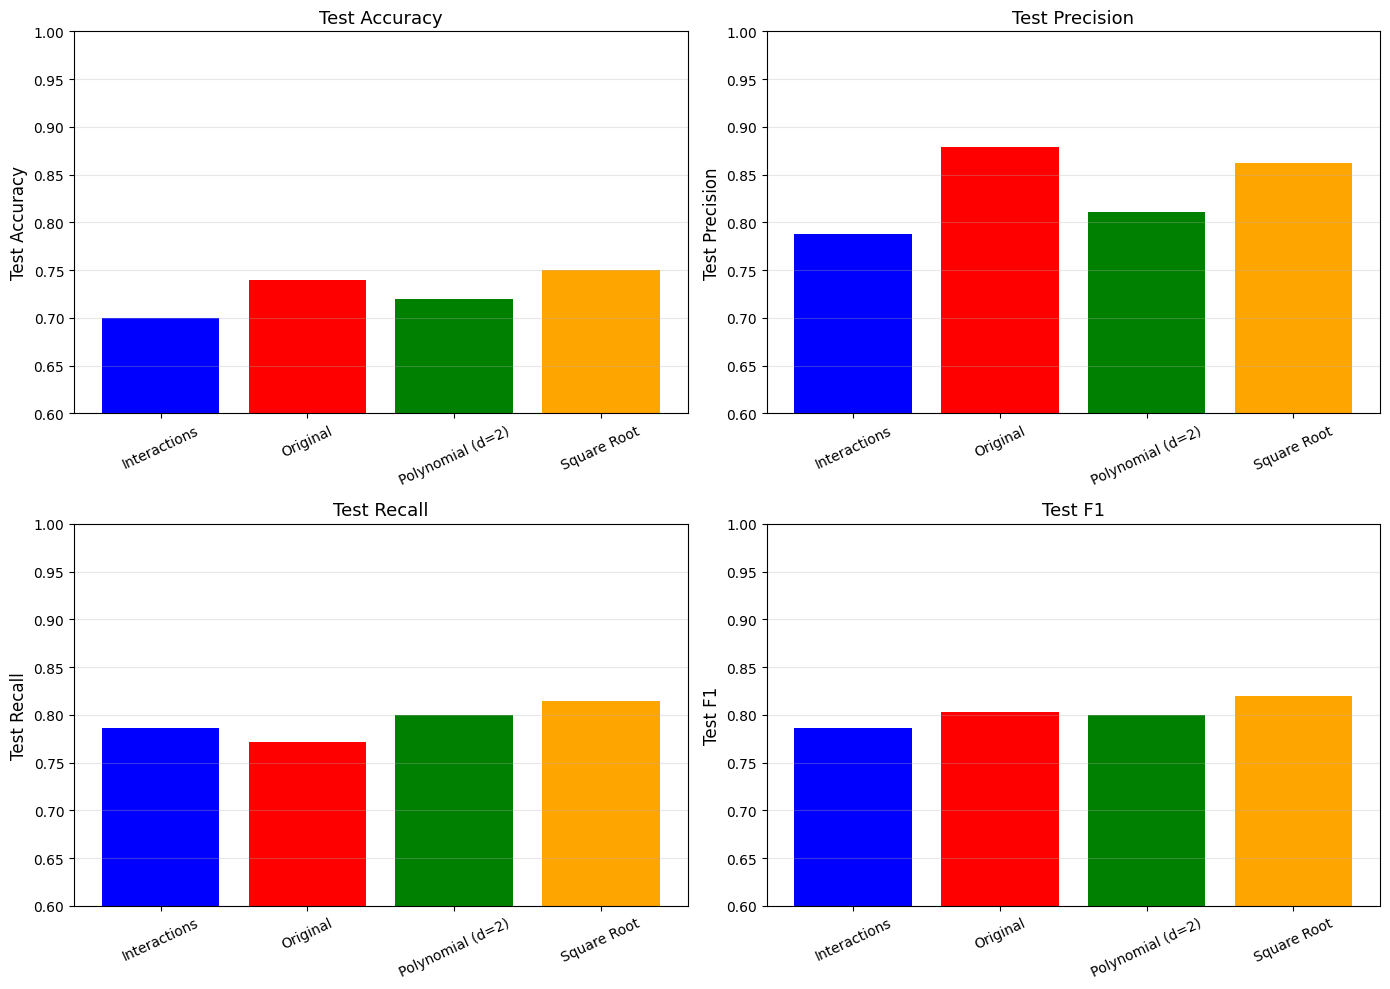

Saved 'nn_test_metric_comparison.png'


In [89]:
summary_nn = (
    nn_all_results_df
    .groupby('feature_version')[['test_acc', 'test_precision', 'test_recall', 'test_f1']]
    .max()      # best model per feature transformation
    .round(4)
)

print("Neural Network Test summary by feature set (max values):")
print(summary_nn)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics = [
    ('test_acc', 'Test Accuracy'),
    ('test_precision', 'Test Precision'),
    ('test_recall', 'Test Recall'),
    ('test_f1', 'Test F1')
]

colors = ['blue', 'red', 'green', 'orange']   # must match feature order

for ax, (metric, title) in zip(axes, metrics):
    values = summary_nn[metric]

    ax.bar(values.index, values.values, color=colors)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(title, fontsize=13)

    # Optional: same y-scale boundaries for consistency
    ax.set_ylim(0.60, 0.90)
    ax.set_yticks(np.arange(0.60, 1.01, 0.05))

    ax.tick_params(axis='x', rotation=25)
    ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('nn_test_metric_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved 'nn_test_metric_comparison.png'")
